# Bootstrapped Regression

Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   scipy.stats import ttest_1samp
from   tqdm import tqdm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
tqdm.pandas()

Get raw Data

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\QualityShocks\root\src")
from FullSampleRegression import FullSampleRegression
from BootstrappedSampleRegression import BootstrappedRegression

In [4]:
def get_full_sample() -> pd.DataFrame:    

    keep_tickers = [
        "europe", "global", "global_ex_usa", "pacific", "usa", "quality", 
        "PLEVERUS", "PPROFTUS", "PEARNVUS"]
    
    df_out       = (FullSampleRegression().get_full_sample_ols().query(
        "variable == @keep_tickers"))
    
    return df_out

df_full_sample = get_full_sample()

## Get Bootstrapped OLS Sharpe

In [5]:
def get_sharpe_comparison(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.assign(
        signal_rtn = lambda x: np.sign(x.lag_resid) * x.value)
        [["variable", "date", "value", "signal_rtn"]].
        rename(columns = {
            "variable": "region",
            "value"   : "rtn"}).
        melt(id_vars = ["date", "region"]).
        drop(columns = ["date"]).
        groupby(["region", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_fs_sharpe = get_sharpe_comparison(df_full_sample)

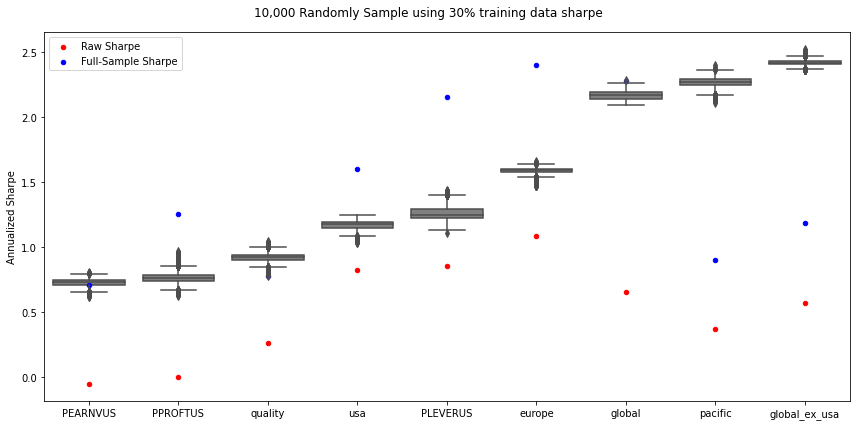

In [6]:
def plot_bootstrap_sharpe(df_fs_sharpe: pd.DataFrame) -> plt.Figure:
    
    df_sharpe = BootstrappedRegression().get_bootsrapped_sharpe()

    fig, axes = plt.subplots(figsize = (12,6))

    (sns.boxplot(
        color = "grey",
        ax    = axes,
        data  = df_sharpe,
        x     = "variable",
        y     = "sharpe",
        order = [
            "PEARNVUS", "PPROFTUS", "quality", "usa", "PLEVERUS", "europe", 
            "global", "pacific", "global_ex_usa"]))

    (df_fs_sharpe.query(
        "variable == 'rtn'").
        plot(
            ax    = axes,
            kind  = "scatter", 
            x     = "region",
            y     = "sharpe",
            color = "red",
            label = "Raw Sharpe"))

    (df_fs_sharpe.query(
        "variable != 'rtn'").
        plot(
            ax    = axes,
            kind  = "scatter", 
            x     = "region",
            y     = "sharpe",
            color = "blue",
            label = "Full-Sample Sharpe"))
    
    fig.suptitle("10,000 Randomly Sample using 30% training data sharpe")
    axes.set_ylabel("Annualized Sharpe"); axes.set_xlabel("")
    plt.tight_layout()
    
plot_bootstrap_sharpe(df_fs_sharpe)

## Compare Worst Sharpes

In [7]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.set_index(
        "date").
        sort_index().
        assign(
            fs_rtn    = lambda x: np.sign(x.lag_resid) * x.value,
            yhat      = lambda x: (x.beta * x.VIX_shock) + x.const,
            resid     = lambda x: x.value - x.yhat,
            lag_resid = lambda x: x.resid.shift(),
            bs_rtn    = lambda x: np.sign(x.lag_resid) * x.value)
        [["value", "fs_rtn", "bs_rtn"]])
    
    return df_out

def get_bs_rtn(df_full_sample: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = BootstrappedRegression().get_bootsrapped_sharpe()
    df_min_sharpe = (df_sharpe.drop(
        columns = ["sim"]).
        groupby("variable").
        min().
        merge(right = df_sharpe, how = "inner", on = ["variable", "sharpe"]))

    df_tmp = (BootstrappedRegression().bootstrap_ols().merge(
        right = df_min_sharpe, how = "inner", on = ["variable", "sim"])
        [["variable", "index", "val"]].
        rename(columns = {"index": "param"}).
        pivot(index = "variable", columns = "param", values = "val").
        rename(columns = {"VIX_shock": "beta"}).
        merge(right = df_full_sample, how = "inner", on = ["variable"]))

    df_out = (df_tmp.groupby(
        "variable").
        apply(_get_rtn).
        reset_index())
    
    return df_out

df_bs_rtn = get_bs_rtn(df_full_sample)

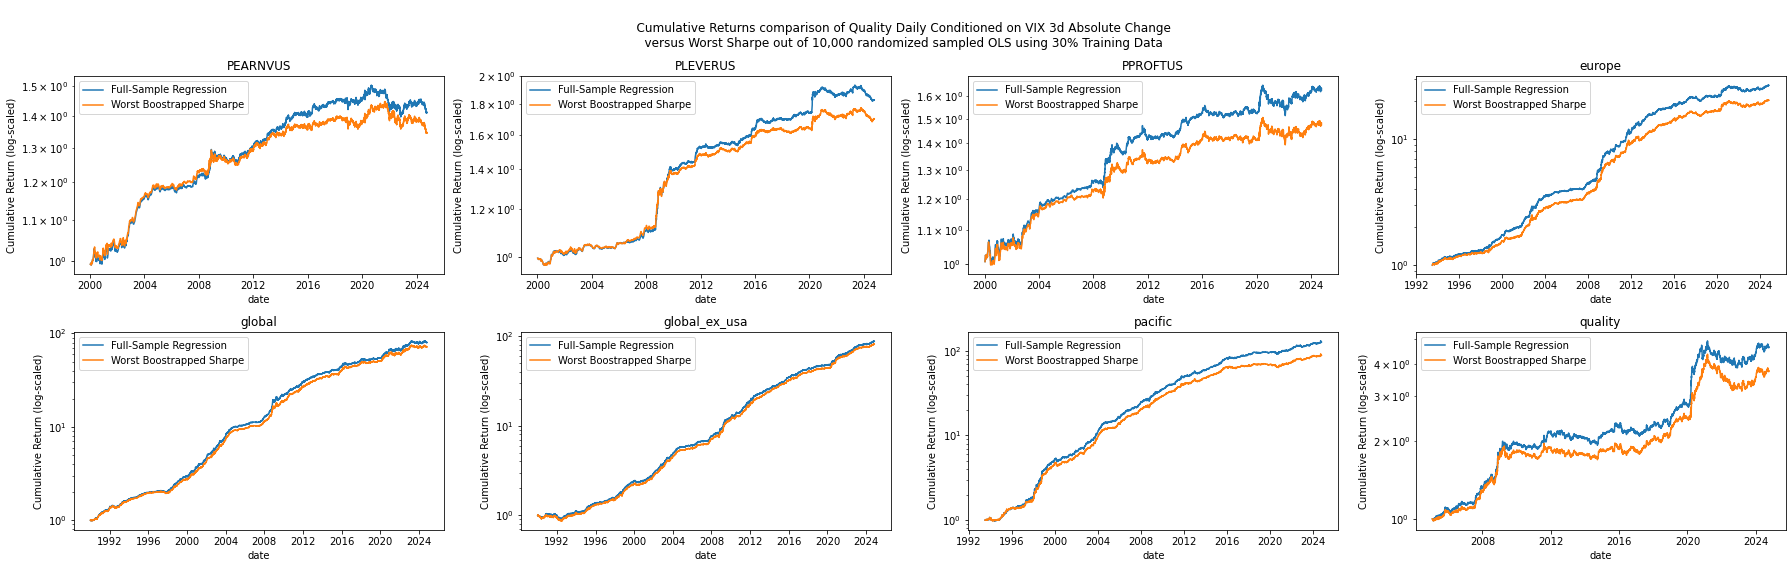

In [8]:
def plot_worst_sharpe(df_bs_rtn: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (25,8))
    variables = df_bs_rtn.variable.drop_duplicates().sort_values().to_list()

    for variable, ax in zip(variables, axes.flatten()):

        (df_bs_rtn.query(
            "variable == @variable").
            set_index("date").
            drop(columns = ["variable", "value"]).
            rename(columns = {
                "fs_rtn": "Full-Sample Regression",
                "bs_rtn": "Worst Boostrapped Sharpe"}).
            apply(lambda x: np.cumprod(1 + x)).
            plot(
                ax     = ax,
                logy   = True,
                ylabel = "Cumulative Return (log-scaled)",
                title  = variable))

    fig.suptitle('''
    Cumulative Returns comparison of Quality Daily Conditioned on VIX 3d Absolute Change
    versus Worst Sharpe out of 10,000 randomized sampled OLS using 30% Training Data''')
    plt.tight_layout()
    
plot_worst_sharpe(df_bs_rtn)

In [9]:
def get_all_sharpe(df_bs_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_bs_rtn.rename(
        columns = {
            "variable": "region",
            "value"   : "raw_rtn"}).
        melt(id_vars = ["date", "region"]).
        drop(columns = ["date"]).
        groupby(["region", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out


df_all_sharpe = get_all_sharpe(df_bs_rtn)

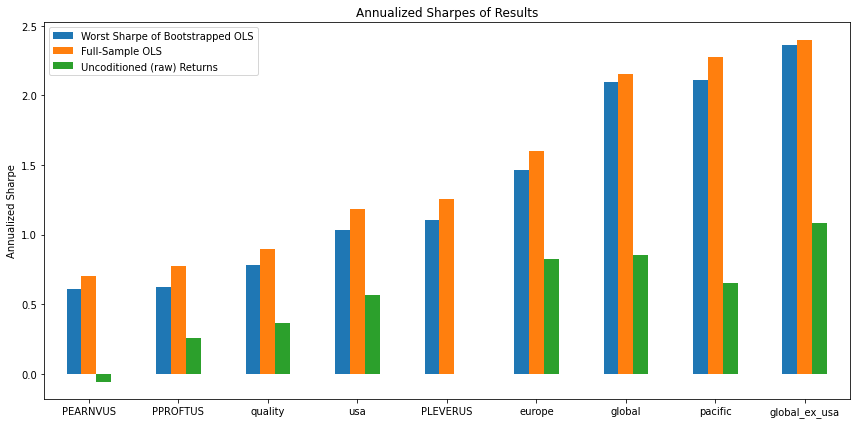

In [10]:
def plot_all_sharpes(df_all_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_all_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "region", columns = "", values = "sharpe").
        sort_values("bs_rtn").
        rename(columns = {
            "bs_rtn" : "Worst Sharpe of Bootstrapped OLS",
            "fs_rtn" : "Full-Sample OLS",
            "raw_rtn": "Uncoditioned (raw) Returns"}).
        plot(
            kind    = "bar",
            figsize = (12,6),
            xlabel  = "",
            rot     = 0,
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpes of Results"))
    
    plt.tight_layout()
    
plot_all_sharpes(df_all_sharpe)